In [1]:
import numpy as np
import pandas as pd
import shap
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, GroupKFold, StratifiedGroupKFold, RepeatedKFold, StratifiedKFold, GridSearchCV, KFold
from sklearn import metrics, linear_model
from xgboost import XGBClassifier, XGBRegressor
import os
import sys
import matplotlib.pyplot as plt
import pickle
import statsmodels.formula.api as smf
from datetime import datetime

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany']

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
stat=pd.read_csv('../outputs/summary_stats/summary_UF_all_reweighted.csv')
d2c=stat.loc[:,['cities','Dist. to center']]
d2c.rename(columns={'cities':'City'},inplace=True)
d2c.head()

,City,Dist. to center
0,Berlin,8.426453
1,Dresden,4.912877
2,Düsseldorf,4.461267
3,Frankfurt am Main,4.954017
4,Kassel,2.896925


In [3]:
city0='Berlin'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
df0['Commute_Trip']=0
df0.loc[df0['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1
#print(len(df0.columns), 'columns in the data for ', city0)
df0=df0.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res',
#'PopDensity_res','BuildDensity_res', 
'UrbPopDensity_res', 'UrbBuildDensity_res',
'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
'LU_Comm_res',  'Commute_Trip','Age','Trip_Distance']] # 'LU_Road_res', 'LU_Urban_res',
df0['City']=city0
df0=df0.merge(d2c)
df0['DistCenter_res_pc']=100*df0['DistCenter_res']/df0['Dist. to center']
df0=df0.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res_pc',
'UrbPopDensity_res', 'UrbBuildDensity_res',
'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
'LU_Comm_res',  'Commute_Trip','Age','Trip_Distance','City']]
df0['Country']='Germany'
df_all=df0.copy()

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
city0='Berlin'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
df0['Commute_Trip']=0
df0.loc[df0['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1
#print(len(df0.columns), 'columns in the data for ', city0)
df0=df0.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res',
#'PopDensity_res','BuildDensity_res', 
'UrbPopDensity_res', 'UrbBuildDensity_res',
'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
'LU_Comm_res',  'Commute_Trip','Age','Trip_Distance']] # 'LU_Road_res', 'LU_Urban_res',
df0['City']=city0
df0=df0.merge(d2c)
df0['DistCenter_res_pc']=100*df0['DistCenter_res']/df0['Dist. to center']
df0=df0.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res_pc',
'UrbPopDensity_res', 'UrbBuildDensity_res',
'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
'LU_Comm_res',  'Commute_Trip','Age','Trip_Distance','City']]
df0['Country']='Germany'
df_all=df0.copy()

cities0=['Dresden','Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
for city1 in cities0:
        print(city1)
        df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
        df1['Commute_Trip']=0
        df1.loc[df1['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1

        df1['City']=city1
        df1=df1.merge(d2c)
        df1['DistCenter_res_pc']=100*df1['DistCenter_res']/df1['Dist. to center']

        df1=df1.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res_pc',
        'UrbPopDensity_res', 'UrbBuildDensity_res',
        'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
        'LU_Comm_res', 'Commute_Trip','Age','Trip_Distance','City']]
        df1['Country']='Germany'
        if len(df1.columns==df_all.columns):
                df_all=pd.concat([df_all,df1])
                print(city1, 'added.')
                print(len(df_all), 'rows in the combined dataframe')
df_DE=df_all.copy()

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


Dresden
Dresden added.
126573 rows in the combined dataframe
Leipzig
Leipzig added.
138169 rows in the combined dataframe
Magdeburg
Magdeburg added.
147545 rows in the combined dataframe
Potsdam
Potsdam added.
153368 rows in the combined dataframe
Frankfurt am Main
Frankfurt am Main added.
159403 rows in the combined dataframe
Düsseldorf
Düsseldorf added.
183247 rows in the combined dataframe
Kassel
Kassel added.
192614 rows in the combined dataframe


Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
# FR, other
city0='Clermont'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
df0['Commute_Trip']=0
df0.loc[df0['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1

df0['City']=city0
df0=df0.merge(d2c)
df0['DistCenter_res_pc']=100*df0['DistCenter_res']/df0['Dist. to center']
df0=df0.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res_pc',
'UrbPopDensity_res', 'UrbBuildDensity_res',
'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
'LU_Comm_res',  'Commute_Trip','Age','Trip_Distance','City']]

df0['Country']='France'
df_all=df0.copy()

cities0=['Toulouse','Montpellier','Lyon','Nantes','Nimes','Lille','Dijon','Paris']
for city1 in cities0:
        print(city1)
        df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
        df1['Commute_Trip']=0
        df1.loc[df1['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1
        df1['City']=city1
        df1=df1.merge(d2c)
        df1['DistCenter_res_pc']=100*df1['DistCenter_res']/df1['Dist. to center']

        df1=df1.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res_pc',
        'UrbPopDensity_res', 'UrbBuildDensity_res',
        'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
        'LU_Comm_res', 'Commute_Trip','Age','Trip_Distance','City']]

        print(len(df1.columns), 'columns in the data for ', city1)
        df1['City']=city1
        df1['Country']='France'
        if len(df1.columns==df_all.columns):
                df_all=pd.concat([df_all,df1])
                print(city1, 'added.')
                print(len(df_all), 'rows in the combined dataframe')
df_FR=df_all.copy()

Toulouse
13 columns in the data for  Toulouse
Toulouse added.
49864 rows in the combined dataframe
Montpellier
13 columns in the data for  Montpellier
Montpellier added.
80127 rows in the combined dataframe
Lyon
13 columns in the data for  Lyon
Lyon added.
132884 rows in the combined dataframe
Nantes
13 columns in the data for  Nantes
Nantes added.
167926 rows in the combined dataframe
Nimes
13 columns in the data for  Nimes
Nimes added.
179143 rows in the combined dataframe
Lille
13 columns in the data for  Lille
Lille added.
215992 rows in the combined dataframe
Dijon
13 columns in the data for  Dijon
Dijon added.
230246 rows in the combined dataframe
Paris
13 columns in the data for  Paris
Paris added.
293160 rows in the combined dataframe


In [6]:
df=pd.read_csv('../outputs/Combined/' + 'Madrid' + '_UF.csv',dtype={'Ori_geocode': str, 'Des_geocode': str,'Res_geocode': str })
df['Commute_Trip']=0
df.loc[df['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1

df['City']='Madrid'
df=df.merge(d2c)
df['DistCenter_res_pc']=100*df['DistCenter_res']/df['Dist. to center']

df_UF=df.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res_pc',
'UrbPopDensity_res', 'UrbBuildDensity_res',
'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
'LU_Comm_res',  'Commute_Trip','Age','Trip_Distance','City']]


df_UF['Country']='Spain'
df_Madrid=df_UF.copy()

In [7]:
df=pd.read_csv('../outputs/Combined/' + 'Wien' + '_UF.csv',dtype={'Ori_geocode': str, 'Des_geocode': str,'Res_geocode': str })
df['Commute_Trip']=0
df.loc[df['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1

df['City']='Wien'
df=df.merge(d2c)
df['DistCenter_res_pc']=100*df['DistCenter_res']/df['Dist. to center']

df_UF=df.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res_pc',
'UrbPopDensity_res', 'UrbBuildDensity_res',
'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',
'LU_Comm_res',  'Commute_Trip','Age','Trip_Distance','City']]

df_UF['Country']='Austria'
df_Wien=df_UF.copy()

In [8]:
del df_UF
df_UF=pd.concat([df_DE,df_FR,df_Madrid,df_Wien],ignore_index=True)
df_UF['Res_geocode']= df_UF['City'] + '_' + df_UF['Res_geocode'].astype(str)
df_UF.drop(columns='City',inplace=True)
df_UF.head()

,Res_geocode,DistSubcenter_res,DistCenter_res_pc,UrbPopDensity_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,LU_UrbFab_res,LU_Comm_res,Commute_Trip,Age,Trip_Distance,Country
0,Berlin_10115,2.761334,23.413879,11691.822806,9.010181e+06,39.380867,127.710059,0.395459,0.366144,1,29,729.0,Germany
1,Berlin_10115,2.761334,23.413879,11691.822806,9.010181e+06,39.380867,127.710059,0.395459,0.366144,1,29,729.0,Germany
2,Berlin_10115,2.761334,23.413879,11691.822806,9.010181e+06,39.380867,127.710059,0.395459,0.366144,1,46,6259.0,Germany
3,Berlin_10115,2.761334,23.413879,11691.822806,9.010181e+06,39.380867,127.710059,0.395459,0.366144,1,46,6259.0,Germany
4,Berlin_10115,2.761334,23.413879,11691.822806,9.010181e+06,39.380867,127.710059,0.395459,0.366144,1,46,1474.0,Germany


In [9]:
df_UF['Country'].value_counts()

France     293160
Germany    192614
Spain      168588
Austria     19772
Name: Country, dtype: int64

In [10]:
count=df_UF.groupby('Res_geocode')['Trip_Distance'].count().reset_index()
count.rename(columns={'Trip_Distance':'count'},inplace=True)
Res_geocode_country=df_UF.loc[:,['Res_geocode','Country']].drop_duplicates()
df_UF=df_UF.groupby('Res_geocode').mean().drop_duplicates() #
df_UF.reset_index(inplace=True)
df_UF=df_UF.merge(Res_geocode_country)

df_UF=df_UF.merge(count)
df_UF=df_UF.loc[df_UF['count']>4,]

df_UF['UrbPopDensity_res']=0.01*df_UF['UrbPopDensity_res'] # convert from per/km2 to per/ha
df_UF.loc[:,['LU_UrbFab_res','LU_Comm_res','Commute_Trip']]=100*df_UF.loc[:,['LU_UrbFab_res','LU_Comm_res','Commute_Trip']] # convert to percentages
df_UF['UrbBuildDensity_res']=1e-6*df_UF['UrbBuildDensity_res'] # convert from m3/km2 to m3/m2 
df_UF.dropna(subset=['Trip_Distance'],inplace=True)

df_agg=df_UF.copy()
N=len(df_UF)
df0=df_UF.copy()

#df_agg.sort_values(by='Res_geocode',inplace=True)
df_agg.dropna(subset=['Trip_Distance'],inplace=True)
df_agg.loc[:,['Country_Germany','Country_France','Country_Spain','Country_Austria']]=0
df_agg.loc[df_agg['Country']=='Germany','Country_Germany']=1
df_agg.loc[df_agg['Country']=='France','Country_France']=1
df_agg.loc[df_agg['Country']=='Spain','Country_Spain']=1
df_agg.loc[df_agg['Country']=='Austria','Country_Austria']=1



target='Trip_Distance'

X=df_agg.drop(columns=['Res_geocode','count','Country',target])
y=df_agg['Trip_Distance']

In [11]:
n_parameter_all = 100
lr_parameter_all = 0.05
md_parameter_all = 4

In [12]:
# cv = RepeatedKFold(n_splits=5,n_repeats=8,random_state=1)
# PS = {"learning_rate": [0.01, 0.05,0.1,0.2], 
#         "n_estimators": [100,200, 300],
#         "max_depth":[2,3,4]}

In [13]:
# tuning_all = GridSearchCV(estimator=XGBRegressor(verbosity=0), param_grid=PS, cv=cv, scoring="r2",return_train_score=True)
# tuning_all.fit(X,y)

# print('best hyper-parameters identified by HPO')
# print(tuning_all.best_params_)
# print('r2 with best hyper-parameters')
# print(tuning_all.best_score_)
# cv_res_all=tuning_all.cv_results_

# n_parameter_all = tuning_all.best_params_['n_estimators']
# lr_parameter_all = tuning_all.best_params_['learning_rate']
# md_parameter_all = tuning_all.best_params_['max_depth']

# # save results of HPO, and full model r2
# r8=['rkf_gridSearch','agg_postcode','5splits_10repeats',tuning_all.best_params_['learning_rate'],tuning_all.best_params_['max_depth'],tuning_all.best_params_['n_estimators'],round(tuning_all.best_score_,3),round(cv_res_all['std_test_score'][tuning_all.best_index_],3),N] #
# HPO_summary=pd.DataFrame([r8],columns=['CV_Type','Sample','CV_params','LR','MD','N_est','R2_best','SD_best','N_obs']) # the last element in this case is the sd of f1 scores in the fold which produced best results

In [14]:
y_predict = pd.DataFrame()
y_predict2 = pd.DataFrame()
y_test = pd.DataFrame()
y_test2 = pd.DataFrame()
summ_table_list=[]

shap_values= pd.DataFrame() 

model = XGBRegressor(
max_depth=md_parameter_all, 
n_estimators=n_parameter_all, 
learning_rate=lr_parameter_all)

# if doing the repeated cv and creation of shap values
r2ml=[]
r2lr=[]

In [15]:
cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=2)
city='All'

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is depreca

GBDT Model r2: All
0.527687784821123
LR Model r2: All
0.5304620522138306
0
1
2
3
4
5


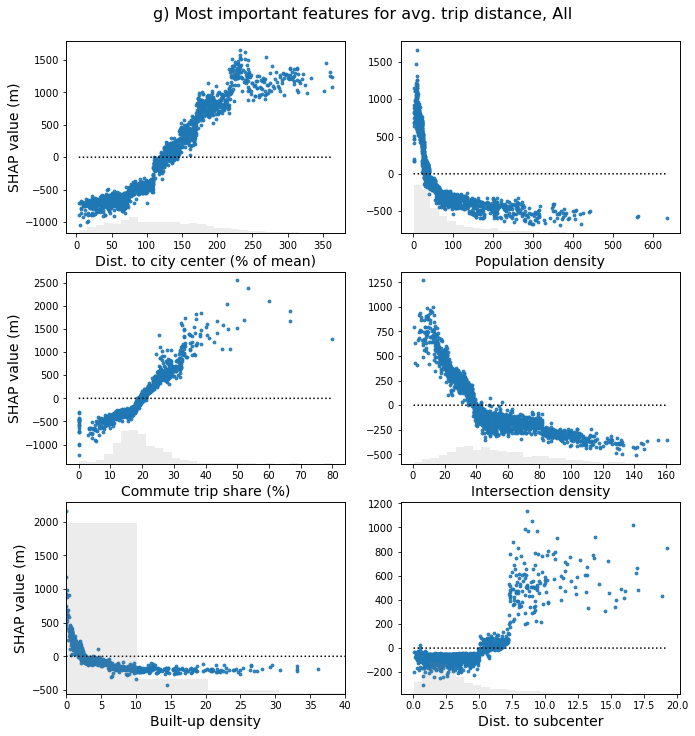

In [16]:
form_str="Trip_Distance ~ DistSubcenter_res + DistCenter_res_pc + UrbPopDensity_res + UrbBuildDensity_res  + IntersecDensity_res + street_length_res + LU_Comm_res + LU_UrbFab_res + Commute_Trip + Age + Country" 
writer = pd.ExcelWriter('../outputs/ML_Results/dist_LR/'  + city + '.xlsx', engine='openpyxl')
for train_idx, test_idx in cv.split(X): # select here 
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        df_train, df_test = df0.iloc[train_idx], df0.iloc[test_idx]
        y_test_fold2=df_test['Trip_Distance']
        id=datetime.now().strftime("%S%f")
        #print('id',id)

        # train & predict
        model.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_test, y_test_fold)])
        y_predict_fold = pd.Series(model.predict(X_test), index=X_test.index)
        r2ml.extend([metrics.r2_score(y_test_fold.array, y_predict_fold.array)])
        # explain
        explainer = shap.TreeExplainer(model)
        
        shap_values_fold = explainer.shap_values(X_test,check_additivity=False)
        
        shap_values_fold = pd.DataFrame(shap_values_fold, index=X_test.index, columns=X.columns) 

        y_predict = pd.concat([y_predict, y_predict_fold], axis=0)
        y_test = pd.concat([y_test, y_test_fold], axis=0)

        shap_values = pd.concat([shap_values, shap_values_fold], axis=0)
        
        lin_reg = smf.ols(form_str, data=df_train).fit()
        yhat=np.asarray(lin_reg.predict(df_test.drop(columns='Trip_Distance')))
        y_predict_fold2 = pd.Series(yhat, index=df_test.index)
        y_predict2 = pd.concat([y_predict2, y_predict_fold2], axis=0)
        y_test2 = pd.concat([y_test2, y_test_fold2], axis=0)
        
        r2lr.extend([metrics.r2_score(y_test_fold.array, y_predict_fold2.array)])

        coeff=lin_reg.params.reset_index()
        coeff.rename(columns={'index':'param',0:'coefficient'},inplace=True)

        pval=lin_reg.pvalues.reset_index()
        pval.rename(columns={'index':'param',0:'p'},inplace=True)

        summ_table=pd.concat([coeff,pval['p']],axis=1)
        summ_table['param']=summ_table['param'].str.replace('FeatureO_','')

        st_list_fold=[summ_table.drop(columns='param').to_numpy()]
        summ_table_list.append(st_list_fold)

        summ_table.to_excel(writer, sheet_name='summ' + id,index=False)
# Close the Pandas Excel writer and output the Excel file.
writer.save()
writer.close()

mdarray=np.array(summ_table_list).squeeze()
means=np.nanmean(mdarray,axis=0)
means_df=pd.DataFrame(data=np.hstack((np.reshape(summ_table['param'].to_numpy(),(len(summ_table),1)),means)),columns=summ_table.columns.values)
means_df.to_csv('../outputs/ML_Results/dist_LR/'  + city + '_mean.csv',index=False)

y_test = y_test.squeeze(axis=1)
y_test2 = y_test2.squeeze(axis=1)
y_predict = y_predict.squeeze(axis=1)
y_predict2 = y_predict2.squeeze(axis=1)
r2_model=metrics.r2_score(y_test, y_predict)
r2_model_reg=metrics.r2_score(y_test2, y_predict2)
print('GBDT Model r2: ' + city)
print(r2_model)
print('LR Model r2: ' + city)
print(r2_model_reg)

r8=['rkf_gridSearch','agg_postcode','5splits_10repeats',lr_parameter_all,md_parameter_all,n_parameter_all,N] #
HPO_summary=pd.DataFrame([r8],columns=['CV_Type','Sample','CV_params','LR','MD','N_est','N_obs']) # the last element in this case is the sd of f1 scores in the fold which produced best results
HPO_summary['R2_full_ML']=r2_model
HPO_summary['R2_full_LR']=r2_model_reg
HPO_summary['City']=city
HPO_summary.to_csv('../outputs/ML_Results/' + city + '_HPO_dist_agg_summary.csv',index=False)

r2ml=pd.DataFrame(r2ml)
r2ml.columns=['GBDT']
r2ml['LR']=r2lr
r2ml.to_csv('../outputs/ML_Results/' + city + '_HPO_dist_agg_r2.csv',index=False)

X_disp=[re.sub('featureD_','', x) for x in X.columns]

shap_values=shap_values.sort_index()
shap_values.reset_index(inplace=True)
shap_values=shap_values.groupby('index').mean().reset_index()
shap_values.drop(columns=['index'],inplace=True)

shap.summary_plot(shap_values.sort_index().to_numpy(), X.sort_index(),feature_names=X_disp,max_display=14,show=False)
plt.title('Feature Influence for Trip Distance, ' + city + ', R2: ' + round(r2_model,3).astype(str))
plt.xlabel("SHAP value (impact on distance, in m)")
plt.savefig('../outputs/ML_Results/result_figures/dist_agg/' + city + '_FI_distance.png',facecolor='w',dpi=65,bbox_inches='tight')
plt.close()
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_disp, shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

#n=importance_df[:10].index
n=importance_df.loc[importance_df['column_name'].isin(['DistCenter_res_pc','DistSubcenter_res','UrbBuildDensity_res','IntersecDensity_res','UrbPopDensity_res','street_length_res','LU_Comm_res','LU_UrbFab_res','Age','Commute_Trip'])].index


X.sort_index(inplace=True)
data=X.sort_index().iloc[:,n]
values=shap_values.sort_index().iloc[:,n]

xl=[]
yl=[]
y0=[]

for i in range(len(n)):
        dftemp=pd.DataFrame({'d':data.iloc[:,i],'v':values.iloc[:,i]})
        dftemp=dftemp.groupby('d')['v'].mean().reset_index()
        dftemp['v0']=0
        xl.append(dftemp['d'].values)
        yl.append(dftemp['v'].values)
        y0.append(dftemp['v0'].values)

data.rename(columns={'DistCenter_res_pc':'Dist. to city center (% of mean)','UrbBuildDensity_res':'Built-up density','IntersecDensity_res':'Intersection density',
                     'LU_Comm_res':'Commercial area (%)','LU_UrbFab_res':'Urban Fabric area (%)','street_length_res':'Avg. street length',
                     'UrbPopDensity_res':'Population density','DistSubcenter_res':'Dist. to subcenter','transit_accessibility':'Transit accessibility',
                     'Commute_Trip':'Commute trip share (%)','bike_lane_share_res':'Cycle lane share (%)'},inplace=True)
if city == 'All': let='g'

fig = plt.figure(figsize=(11,12))
for i in range(0,6):
        print(i)
        ax1 = fig.add_subplot(321+i)
        xs=data.iloc[:,i]
        ys=values.iloc[:,i]
        x=xl[i]
        y1=y0[i]
        y2=yl[i]
        xlab=data.columns[i]

        ax1.scatter(xs,ys,alpha=0.9,s=8)
        plt.plot(x,y1,'k:',label='zero')
        if (xlab== 'Built-up density'):
                plt.xlim([0, 40])
        if i%2==0:
                ax1.set_ylabel('SHAP value (m)',size=14)
        else:
                ax1.set_ylabel('')
        ax1.set_xlabel(xlab,size=14)

        ax2 = ax1.twinx() 
        if len(xs.unique())==2:
                ax2.hist(xs,bins=[-0.5,0.5,1.5], align='mid',color='gray',alpha=0.25)
                ax2.set_xticks([-.5,0,0.5,1,1.5])
        else:
                ax2.hist(xs,bins=30,color='gray',alpha=0.15)
                ax2.set_ylim(0,len(data))
        ax2.set_yticks([])
plt.suptitle(let + ') ' +  "Most important features for avg. trip distance, " + city.replace('_',', '),y=0.92,size=16)
plt.savefig('../outputs/ML_Results/result_figures/dist_agg/' + city + '_main6.png',facecolor='w',dpi=65,bbox_inches='tight')

# save shap_values, to enable later re-creation and editing of shap plots
with open('../outputs/ML_Results/shap/dist_agg/' + city + '.pkl', 'wb') as f:
        pickle.dump(shap_values, f)

with open('../outputs/ML_Results/shap/dist_agg/' + city + '_importance.pkl', 'wb') as g:
        pickle.dump(importance_df, g)

with open('../outputs/ML_Results/shap/dist_agg/' + city + '_df.pkl', 'wb') as h:
        pickle.dump(df_agg, h)

In [17]:
means_df

,param,coefficient,p
0,Intercept,5070.084192,0.0
1,Country[T.France],-1615.701137,0.0
2,Country[T.Germany],-2096.414715,0.0
3,Country[T.Spain],-1365.701543,0.00003
4,DistSubcenter_res,60.965563,0.000971
5,DistCenter_res_pc,9.021174,0.0
6,UrbPopDensity_res,-3.480813,0.000002
7,UrbBuildDensity_res,-3.577809,0.366893
8,IntersecDensity_res,-17.955375,0.0
9,street_length_res,1.843081,0.371888
